In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sku_master=pd.read_csv(r"C:\Users\dhruv\Downloads\b2b\SKU Master.csv")
courier_rates=pd.read_csv(r"C:\Users\dhruv\Downloads\b2b\Courier Company - Rates.csv")
invoice=pd.read_csv(r"C:\Users\dhruv\Downloads\b2b\Invoice.csv")
order_report=pd.read_csv(r"C:\Users\dhruv\Downloads\b2b\Order Report.csv")
pincode=pd.read_csv(r"C:\Users\dhruv\Downloads\b2b\pincodes.csv")

In [3]:
print('SKU MASTER')
print(sku_master.head())
print('courier_rates')
print(courier_rates.head())
print('invoice')
print(invoice.head())
print('order_report')
print(order_report.head())
print('pincode')
print(pincode.head())

SKU MASTER
             SKU  Weight (g)  Unnamed: 2  Unnamed: 3  Unnamed: 4
0  8904223815682         210         NaN         NaN         NaN
1  8904223815859         165         NaN         NaN         NaN
2  8904223815866         113         NaN         NaN         NaN
3  8904223815873          65         NaN         NaN         NaN
4  8904223816214         120         NaN         NaN         NaN
courier_rates
   fwd_a_fixed  fwd_a_additional  fwd_b_fixed  fwd_b_additional  fwd_c_fixed  \
0         29.5              23.6           33              28.3         40.1   

   fwd_c_additional  fwd_d_fixed  fwd_d_additional  fwd_e_fixed  \
0              38.9         45.4              44.8         56.6   

   fwd_e_additional  rto_a_fixed  rto_a_additional  rto_b_fixed  \
0              55.5         13.6              23.6         20.5   

   rto_b_additional  rto_c_fixed  rto_c_additional  rto_d_fixed  \
0              28.3         31.9              38.9         41.3   

   rto_d_additional

In [4]:
print("\nMissing values in Website Order Report:")
print(order_report.isnull().sum())
print("\nMissing values in SKU Master:")
print(sku_master.isnull().sum())
print("\nMissing values in Pincode Mapping:")
print(pincode.isnull().sum())
print("\nMissing values in Courier Invoice:")
print(invoice.isnull().sum())
print("\nMissing values in courier company rates:")
print(courier_rates.isnull().sum())


Missing values in Website Order Report:
ExternOrderNo      0
SKU                0
Order Qty          0
Unnamed: 3       400
Unnamed: 4       400
dtype: int64

Missing values in SKU Master:
SKU            0
Weight (g)     0
Unnamed: 2    66
Unnamed: 3    66
Unnamed: 4    66
dtype: int64

Missing values in Pincode Mapping:
Warehouse Pincode      0
Customer Pincode       0
Zone                   0
Unnamed: 3           124
Unnamed: 4           124
dtype: int64

Missing values in Courier Invoice:
AWB Code                0
Order ID                0
Charged Weight          0
Warehouse Pincode       0
Customer Pincode        0
Zone                    0
Type of Shipment        0
Billing Amount (Rs.)    0
dtype: int64

Missing values in courier company rates:
fwd_a_fixed         0
fwd_a_additional    0
fwd_b_fixed         0
fwd_b_additional    0
fwd_c_fixed         0
fwd_c_additional    0
fwd_d_fixed         0
fwd_d_additional    0
fwd_e_fixed         0
fwd_e_additional    0
rto_a_fixed        

In [5]:
order_report = order_report.drop(columns=['Unnamed: 3', 'Unnamed: 4'])

# Remove unnamed columns from the SKU Master DataFrame
sku_master = sku_master.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

# Remove unnamed columns from the Pincode Mapping DataFrame
pincode = pincode.drop(columns=['Unnamed: 3', 'Unnamed: 4'])

In [6]:
# Merge the Order Report and SKU Master based on SKU
merged_data = pd.merge(order_report, sku_master, on='SKU')
print(merged_data.head())

   ExternOrderNo            SKU  Order Qty  Weight (g)
0     2001827036  8904223818706        1.0         127
1     2001821995  8904223818706        1.0         127
2     2001819252  8904223818706        1.0         127
3     2001816996  8904223818706        1.0         127
4     2001814580  8904223818706        1.0         127


In [7]:
merged_data.shape

(401, 4)

In [8]:
merged_data = merged_data.rename(columns={'ExternOrderNo': 'Order ID'})

In [9]:
abc_courier = pincode.drop_duplicates(subset=['Customer Pincode'])
courier_abc= invoice[['Order ID', 'Customer Pincode','Type of Shipment']]
pincodes= courier_abc.merge(abc_courier,on='Customer Pincode')
print(pincodes.head())

     Order ID  Customer Pincode Type of Shipment  Warehouse Pincode Zone
0  2001806232            507101  Forward charges             121003    d
1  2001806273            486886  Forward charges             121003    d
2  2001806408            532484  Forward charges             121003    d
3  2001806458            143001  Forward charges             121003    b
4  2001807012            515591  Forward charges             121003    d


In [10]:
merged2 = merged_data.merge(pincodes, on='Order ID')

In [11]:
merged2['Weights (Kgs)'] = merged2['Weight (g)'] / 1000

In [12]:
def weight_slab(weight):
    i = round(weight % 1, 1)
    if i == 0.0:
        return weight
    elif i > 0.5:
        return int(weight) + 1.0
    else:
        return int(weight) + 0.5

merged2['Weight Slab (KG)'] = merged2['Weights (Kgs)'].apply(weight_slab)
invoice['Weight Slab Charged by Courier Company']=(invoice['Charged Weight']).apply(weight_slab)

In [13]:
invoice = invoice.rename(columns={'Zone': 'Delivery Zone Charged by Courier Company'})
merged2 = merged2.rename(columns={'Zone': 'Delivery Zone As Per ABC'})
merged2 = merged2.rename(columns={'Weight Slab (KG)': 'Weight Slab As Per ABC'})

In [14]:
total_expected_charge = []

for _, row in merged2.iterrows():
    fwd_category = 'fwd_' + row['Delivery Zone As Per ABC']
    fwd_fixed = courier_rates.at[0, fwd_category + '_fixed']
    fwd_additional = courier_rates.at[0, fwd_category + '_additional']
    rto_category = 'rto_' + row['Delivery Zone As Per ABC']
    rto_fixed = courier_rates.at[0, rto_category + '_fixed']
    rto_additional = courier_rates.at[0, rto_category + '_additional']

    weight_slab = row['Weight Slab As Per ABC']

    if row['Type of Shipment'] == 'Forward charges':
        additional_weight = max(0, (weight_slab - 0.5) / 0.5)
        total_expected_charge.append(fwd_fixed + additional_weight * fwd_additional)
    elif row['Type of Shipment'] == 'Forward and RTO charges':
        additional_weight = max(0, (weight_slab - 0.5) / 0.5)
        total_expected_charge.append(fwd_fixed + additional_weight * (fwd_additional + rto_additional))
    else:
        total_expected_charge.append(0)

merged2['Expected Charge as per ABC'] = total_expected_charge
print(merged2.head())

     Order ID            SKU  Order Qty  Weight (g)  Customer Pincode  \
0  2001827036  8904223818706        1.0         127            173213   
1  2001827036  8904223819093        1.0         150            173213   
2  2001827036  8904223819109        1.0         100            173213   
3  2001827036  8904223818430        1.0         165            173213   
4  2001827036  8904223819277        1.0         350            173213   

  Type of Shipment  Warehouse Pincode Delivery Zone As Per ABC  Weights (Kgs)  \
0  Forward charges             121003                        e          0.127   
1  Forward charges             121003                        e          0.150   
2  Forward charges             121003                        e          0.100   
3  Forward charges             121003                        e          0.165   
4  Forward charges             121003                        e          0.350   

   Weight Slab As Per ABC  Expected Charge as per ABC  
0                 

In [15]:
merged_output = merged2.merge(invoice, on='Order ID')
print(merged_output.head())

     Order ID            SKU  Order Qty  Weight (g)  Customer Pincode_x  \
0  2001827036  8904223818706        1.0         127              173213   
1  2001827036  8904223819093        1.0         150              173213   
2  2001827036  8904223819109        1.0         100              173213   
3  2001827036  8904223818430        1.0         165              173213   
4  2001827036  8904223819277        1.0         350              173213   

  Type of Shipment_x  Warehouse Pincode_x Delivery Zone As Per ABC  \
0    Forward charges               121003                        e   
1    Forward charges               121003                        e   
2    Forward charges               121003                        e   
3    Forward charges               121003                        e   
4    Forward charges               121003                        e   

   Weights (Kgs)  Weight Slab As Per ABC  Expected Charge as per ABC  \
0          0.127                     0.5                

In [16]:
df_diff = merged_output
df_diff['Difference (Rs.)'] = df_diff['Billing Amount (Rs.)'] - df_diff['Expected Charge as per ABC']

df_new = df_diff[['Order ID', 'Difference (Rs.)', 'Expected Charge as per ABC']]

print(df_new.head())

     Order ID  Difference (Rs.)  Expected Charge as per ABC
0  2001827036              61.3                        56.6
1  2001827036              61.3                        56.6
2  2001827036              61.3                        56.6
3  2001827036              61.3                        56.6
4  2001827036              61.3                        56.6


In [17]:
total_correctly_charged = len(df_new[df_new['Difference (Rs.)'] == 0])
total_overcharged = len(df_new[df_new['Difference (Rs.)'] > 0])
total_undercharged = len(df_new[df_new['Difference (Rs.)'] < 0])

# Calculate the total amount in each category
amount_overcharged = abs(df_new[df_new['Difference (Rs.)'] > 0]['Difference (Rs.)'].sum())
amount_undercharged = df_new[df_new['Difference (Rs.)'] < 0]['Difference (Rs.)'].sum()
amount_correctly_charged = df_new[df_new['Difference (Rs.)'] == 0]['Expected Charge as per ABC'].sum()

# Create a new DataFrame for the summary
summary_data = {'Description': ['Total Orders where ABC has been correctly charged',
                                'Total Orders where ABC has been overcharged',
                                'Total Orders where ABC has been undercharged'],
                'Count': [total_correctly_charged, total_overcharged, total_undercharged],
                'Amount (Rs.)': [amount_correctly_charged, amount_overcharged, amount_undercharged]}

df_summary = pd.DataFrame(summary_data)

print(df_summary)

                                         Description  Count  Amount (Rs.)
0  Total Orders where ABC has been correctly charged     12         507.6
1        Total Orders where ABC has been overcharged    382       33750.5
2       Total Orders where ABC has been undercharged      7        -165.2


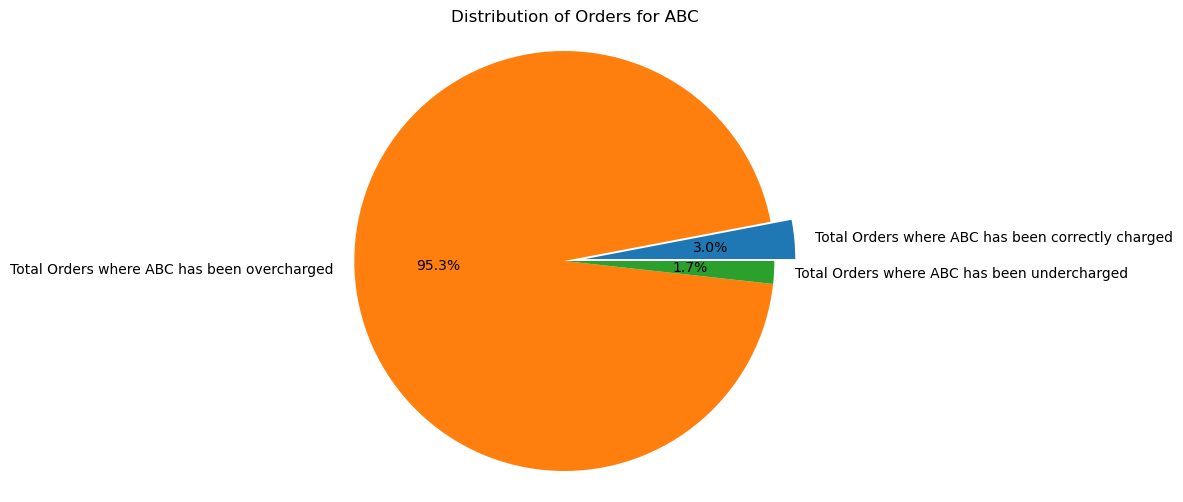

In [18]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = df_summary['Description']
sizes = df_summary['Count']
#colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode the 1st slice (Total Orders where ABC has been correctly charged)

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Orders for ABC')
plt.show()
